# ESDP1 – Homework 1
## ERA5 Data Access (Pelin Su Kaplan)

In [25]:
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Step 1: CDS API configuration

In this step, we initialize the CDS API client (`cdsapi.Client`) that will be used to request ERA5 data.
The client automatically reads the API key stored in the `~/.cdsapirc` file and establishes a connection
to the Copernicus Climate Data Store (CDS) service.

This step only verifies that the connection works. 
No data is downloaded here.

In [26]:
import cdsapi

# Initialize the CDS API client using the credentials stored in ~/.cdsapirc
client = cdsapi.Client()

# Display the client object to confirm successful connection
client

2025-12-03 21:51:48,173 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


# Step 2: ERA5 download request

In this step, I define and submit a download request for a small ERA5 subset using the CDS API client.

For this homework, I request:
- Dataset: **ERA5 single levels** (`reanalysis-era5-single-levels`)
- Variables: 10 m u-component of wind, 10 m v-component of wind, 2 m temperature
- Region: a box over Central Europe
- Time period: a few days in September 2024, at 00, 06, 12, and 18 UTC
- Output format: NetCDF

The request is passed as a Python dictionary to `client.retrieve(...)`, which sends it to the CDS
server and saves the downloaded file to disk.

In [27]:
# Define the ERA5 dataset name on the CDS
dataset = "reanalysis-era5-single-levels"

# Define the download request as a Python dictionary
request = {
    "product_type": "reanalysis",
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
    ],
    "year": "2024",
    "month": "09",
    # A small subset of days to keep the download manageable
    "day": [
        "01", "02", "03", "04", "05",
    ],
    # Four synoptic hours per day
    "time": [
        "00:00", "06:00", "12:00", "18:00",
    ],
    # Area is given as [north, west, south, east] in degrees
    # Here: a rough box over Central Europe
    "area": [
        60,   -10,   # north, west
        45,    20,   # south, east
    ],
    "format": "netcdf",  # NetCDF is convenient for xarray
}

# Define the output filename
target_file = "era5_central_europe_sept2024_small.nc"

# Send the request to CDS and download the data
client.retrieve(dataset, request, target_file)

2025-12-03 21:51:48,798 INFO Request ID is 8c00b3bf-cf65-44c6-9c88-99272c9218ae
2025-12-03 21:51:48,952 INFO status has been updated to accepted
2025-12-03 21:51:58,584 INFO status has been updated to running
2025-12-03 21:52:03,940 INFO status has been updated to successful


417899f183396962274f0b014abf55fc.nc:   0%|          | 0.00/913k [00:00<?, ?B/s]

'era5_central_europe_sept2024_small.nc'

# Step 3: Open dataset with xarray

In [28]:
import xarray as xr

# Path to the downloaded ERA5 NetCDF file
data_file = "era5_central_europe_sept2024_small.nc"

# Open the dataset with xarray
ds = xr.open_dataset(data_file)

# Display the dataset object to see its basic structure
ds

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 20, latitude: 61, longitude: 121)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 160B 2024-09-01 ... 2024-09-05T18...
  * latitude    (latitude) float64 488B 60.0 59.75 59.5 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 968B -10.0 -9.75 -9.5 ... 19.5 19.75 20.0
    expver      (valid_time) <U4 320B ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 590kB ...
    v10         (valid_time, latitude, longitude) float32 590kB ...
    t2m         (valid_time, latitude, longitude) float32 590kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-01T21:19 GRIB to CDM+CF via cfgrib-0.9.1...

# Step 4: Inspect dataset

In this step, we examine the structure of the ERA5 dataset using xarray.
We check the dimensions, coordinates, variables, and basic statistics to
understand what the data contains before plotting or further analysis.

In [29]:
# Inspect the dataset by showing its dimensions, coordinates, variables, and metadata
ds.dims, ds.coords, list(ds.data_vars), ds.attrs

(FrozenMappingWarningOnValuesAccess({'valid_time': 20, 'latitude': 61, 'longitude': 121}),
 Coordinates:
     number      int64 8B ...
   * valid_time  (valid_time) datetime64[ns] 160B 2024-09-01 ... 2024-09-05T18...
   * latitude    (latitude) float64 488B 60.0 59.75 59.5 ... 45.5 45.25 45.0
   * longitude   (longitude) float64 968B -10.0 -9.75 -9.5 ... 19.5 19.75 20.0
     expver      (valid_time) <U4 320B ...,
 ['u10', 'v10', 't2m'],
 {'GRIB_centre': 'ecmf',
  'GRIB_centreDescription': 'European Centre for Medium-Range Weather Forecasts',
  'GRIB_subCentre': np.int64(0),
  'Conventions': 'CF-1.7',
  'institution': 'European Centre for Medium-Range Weather Forecasts',
  'history': '2025-12-01T21:19 GRIB to CDM+CF via cfgrib-0.9.15.1/ecCodes-2.42.0 with {"source": "tmpjrdim979/data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["instant"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'})

## Step 5: Basic plots

In this step, we create a few simple plots from the ERA5 subset to get a first impression of the data.  
The goal is not to perform a full scientific analysis, but to check that

- the values look physically reasonable,
- the units and ranges make sense, and
- the temporal and spatial patterns look plausible.

We use three basic plot types:

1. A time series at a single point (for example 2 m temperature at one grid point).
2. A spatial map of a variable at a single time step.
3. A histogram to inspect the distribution of values.

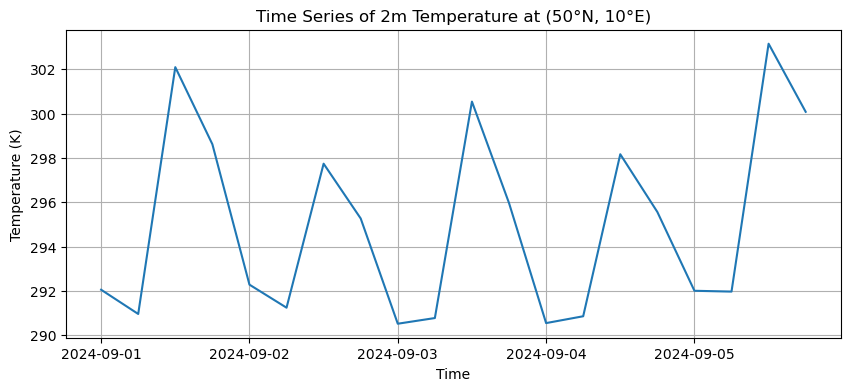

In [30]:
import matplotlib.pyplot as plt

# Select a representative location for a time series (near the center of the domain)
lat0 = 50.0
lon0 = 10.0

# Select the nearest grid point in the dataset
point = ds.sel(latitude=lat0, longitude=lon0, method="nearest")

# ---- Plot 1: Time series of 2m temperature ----
plt.figure(figsize=(10, 4))
plt.plot(point.valid_time, point["t2m"])
plt.title("Time Series of 2m Temperature at (50°N, 10°E)")
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.grid(True)
plt.show()


1- The time series shows that 2 m temperature stays in a realistic range for early September in Central Europe.  
There are clear day–night variations and no obvious outliers, which suggests that the download and decoding worked correctly.

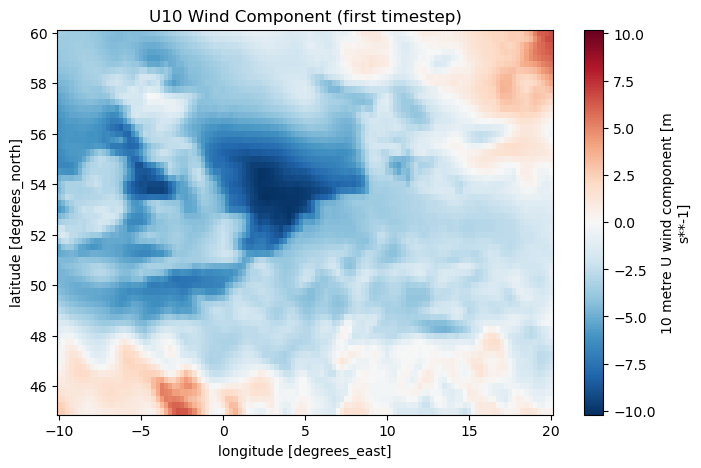

In [31]:
# ---- Plot 2: Spatial map of U10 at the first timestep ----
plt.figure(figsize=(8, 5))
ds["u10"].isel(valid_time=0).plot()
plt.title("U10 Wind Component (first timestep)")
plt.show()

2- The spatial map of 10 m wind speed shows stronger winds over the North Sea and weaker winds over continental areas, which is consistent with typical synoptic patterns.  
No obvious artefacts (such as stripes or missing bands) are visible.

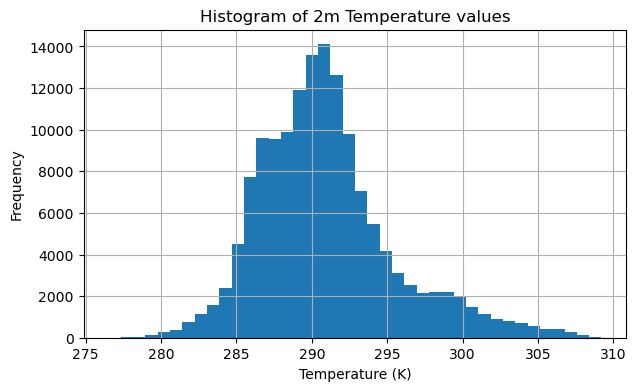

In [32]:
# ---- Plot 3: Histogram of Temperature ----
plt.figure(figsize=(7, 4))
plt.hist(ds["t2m"].values.flatten(), bins=40)
plt.title("Histogram of 2m Temperature values")
plt.xlabel("Temperature (K)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

3- The histogram confirms that most 2 m temperature values lie in a narrow range around realistic early-autumn temperatures.  
Again, there are no extreme outliers, which is another sanity check for the downloaded data.

## Summary of this notebook

This notebook demonstrates how we can

1. set up the CDS API client using a personal API key,
2. request a small ERA5 subset (single levels, 2 m temperature and 10 m winds) for a box around Central Europe in September 2024,
3. download the data as NetCDF,
4. inspect dimensions, coordinates, variables and attributes with `xarray`, and
5. create a few simple plots to check that the data look reasonable.

The script is intentionally limited to a small sample so that it runs quickly on a laptop.  
In the README file, we discuss how this approach could be scaled to larger time periods and domains. 